# Winners Recipe Visualization

This notebook visualizes the "Winner's Recipe" transformations from the MMSeaIce paper, aligned to this dataset:

1. **SAR Normalization (mean/std)**: The SAR channels are already in dB, so we apply standard mean/std normalization (no log10).
2. **Downsampling**: Reduce 512x512 crops to 128x128 for larger effective receptive field.
3. **Month Encoding**: Add month as a 4th channel for seasonal ice behavior.

These techniques address the core issue: at 80m SAR resolution, a CNN's receptive field is too small relative to ice floe sizes. Downsampling forces the model to see macro structure.


In [26]:
import json
import random
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Resolve repo root
repo_root = Path.cwd()
if not (repo_root / 'src').exists():
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root / 'src'))

from dataset import (
    CLASS_NAMES, IGNORE_INDEX, NUM_CLASSES,
    DEFAULT_DOWNSAMPLE_SIZE, DEFAULT_CROP_SIZE
)

data_dir = repo_root / 'data' / 'ai4arctic_hugging face'
memmap_dir = data_dir / 'npy_memmap'

print('Repo:', repo_root)
print('Memmap:', memmap_dir)
print('Default downsample:', DEFAULT_DOWNSAMPLE_SIZE)


Repo: /home/mike1/Arcticv2
Memmap: /home/mike1/Arcticv2/data/ai4arctic_hugging face/npy_memmap
Default downsample: 128


In [27]:
# Load metadata and normalization stats
meta_path = memmap_dir / 'metadata.json'
stats_path = memmap_dir / 'normalization_stats.json'

meta = json.loads(meta_path.read_text()) if meta_path.exists() else {}
stats = json.loads(stats_path.read_text()) if stats_path.exists() else {}

crop_size = meta.get('crop_size', 512)
mean = np.array(stats.get('mean', [0.0, 0.0, 0.0]), dtype=np.float32)
std = np.array(stats.get('std', [1.0, 1.0, 1.0]), dtype=np.float32)

# Approximate ground resolution of ready-to-train dataset
BASE_RES_M = 80
# Global-context target size (same input size, much larger area)
GLOBAL_TARGET_SIZE = 512

local_km = crop_size * BASE_RES_M / 1000

print('Crop size:', crop_size)
print('Channel mean:', mean.tolist())
print('Channel std:', std.tolist())
print('Class names:', CLASS_NAMES)
print(f'Local crop coverage: ~{local_km:.1f} km x {local_km:.1f} km')
print('Global target size:', GLOBAL_TARGET_SIZE)


Crop size: 512
Channel mean: [-0.13354626297950745, -0.19230887293815613, -0.07911176234483719]
Channel std: [0.7163852453231812, 0.4533175230026245, 0.6984074711799622]
Class names: ['OpenWater', 'NewIce', 'YoungIce', 'ThinFirstYearIce', 'ThickFirstYearIce', 'OldIce']
Local crop coverage: ~41.0 km x 41.0 km
Global target size: 512


In [28]:
# Load coordinates
coords_data = np.load(memmap_dir / 'train_coords.npy', allow_pickle=True).item()
coords = coords_data['coords']
scene_names = coords_data['scene_names']
classes_per_crop = coords_data.get('classes', None)

print('Total crops:', len(coords))
print('Total scenes:', len(scene_names))

Total crops: 84652
Total scenes: 445


In [29]:
# Color palette for labels
PALETTE = np.array([
    [0, 0, 139],      # OpenWater - dark blue
    [173, 216, 230],  # NewIce - light blue
    [144, 238, 144],  # YoungIce - light green
    [255, 255, 0],    # ThinFirstYearIce - yellow
    [255, 165, 0],    # ThickFirstYearIce - orange
    [255, 255, 255],  # OldIce - white
], dtype=np.float32) / 255.0
IGNORE_COLOR = np.array([0.5, 0.5, 0.5], dtype=np.float32)


def colorize_label(label):
    """Convert label indices to RGB."""
    rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.float32)
    for c in range(NUM_CLASSES):
        mask = label == c
        if mask.any():
            rgb[mask] = PALETTE[c]
    rgb[label == 255] = IGNORE_COLOR
    return rgb


def load_raw_patch(idx, split='train'):
    """Load raw (un-normalized) patch."""
    scene_idx, r, c = coords[idx]
    scene_name = scene_names[scene_idx]
    scene_dir = memmap_dir / split
    
    image_path = scene_dir / f'{scene_name}_image.npy'
    label_path = scene_dir / f'{scene_name}_label.npy'
    
    image_mmap = np.load(image_path, mmap_mode='r')
    label_mmap = np.load(label_path, mmap_mode='r')
    
    image = image_mmap[:, r:r+crop_size, c:c+crop_size].astype(np.float32)
    label = label_mmap[r:r+crop_size, c:c+crop_size].copy()
    
    return image, label, scene_name, (int(r), int(c))

## 1. SAR Normalization (mean/std)

The AI4Arctic SAR channels are already in dB.
We use the preprocessing mean/std normalization for all channels (no log10, no dB clipping).


In [30]:
def apply_standard_normalization(image):
    """Standard mean/std normalization for all channels (data already in dB)."""
    return (image - mean[:, None, None]) / (std[:, None, None] + 1e-8)


In [31]:
# Find a patch with diverse classes for visualization
def find_diverse_patch():
    """Find patch with multiple ice classes."""
    if classes_per_crop is None:
        return random.randint(0, len(coords) - 1)
    
    # Prefer patches with 3+ classes including rare ones
    rare_classes = {1, 2, 3}  # NewIce, YoungIce, ThinFirstYearIce
    candidates = [
        i for i, classes in enumerate(classes_per_crop)
        if len(classes) >= 3 and any(c in rare_classes for c in classes)
    ]
    
    if candidates:
        return random.choice(candidates)
    
    # Fallback: any patch with 2+ classes
    candidates = [i for i, classes in enumerate(classes_per_crop) if len(classes) >= 2]
    return random.choice(candidates) if candidates else 0


random.seed(42)
patch_idx = find_diverse_patch()
print('Selected patch index:', patch_idx)
print('Classes in patch:', sorted(classes_per_crop[patch_idx]) if classes_per_crop else 'unknown')

Selected patch index: 69751
Classes in patch: [0, 1, 5]


In [32]:
# Load and visualize mean/std normalization comparison
image_raw, label, scene_name, (r, c) = load_raw_patch(patch_idx)

# Apply normalization
image_norm = apply_standard_normalization(image_raw)

print(f'Scene: {scene_name}, position: ({r}, {c})')
print(f'Raw HH range: [{image_raw[0].min():.4f}, {image_raw[0].max():.4f}]')
print(f'Raw HV range: [{image_raw[1].min():.4f}, {image_raw[1].max():.4f}]')
print(f'Raw Inc range: [{image_raw[2].min():.4f}, {image_raw[2].max():.4f}]')
print(f'Norm HH range: [{image_norm[0].min():.2f}, {image_norm[0].max():.2f}]')
print(f'Norm HV range: [{image_norm[1].min():.2f}, {image_norm[1].max():.2f}]')
print(f'Norm Inc range: [{image_norm[2].min():.2f}, {image_norm[2].max():.2f}]')


Scene: 20191016T155300_cis_prep, position: (3328, 768)
Raw HH range: [-2.0078, 1.6045]
Raw HV range: [-1.6416, 2.4551]
Raw Inc range: [-1.2734, -0.9473]
Norm HH range: [-2.62, 2.43]
Norm HV range: [-3.20, 5.84]
Norm Inc range: [-1.71, -1.24]


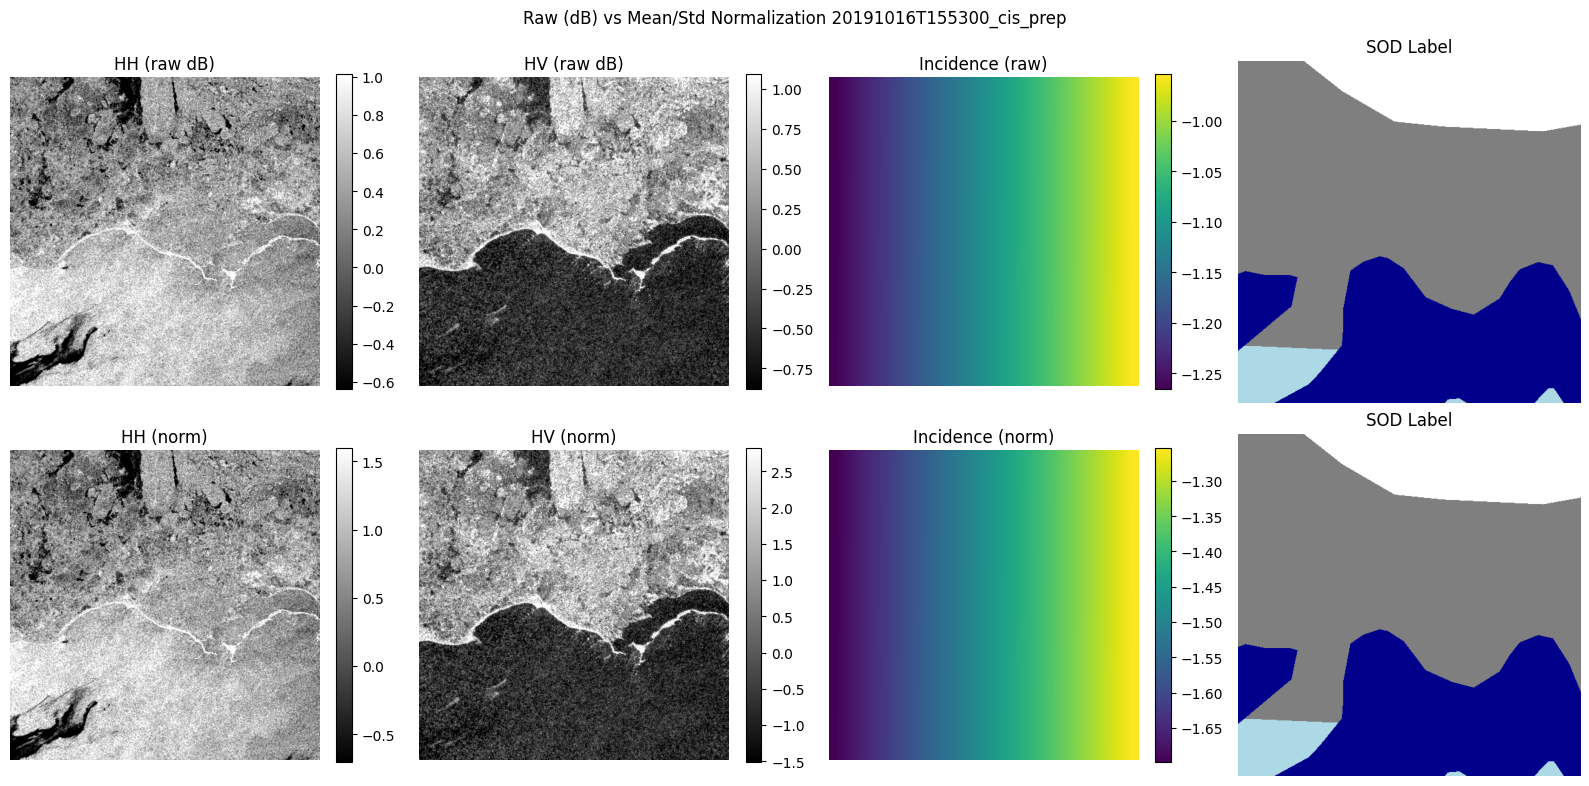

In [34]:
# Side-by-side comparison: Raw vs mean/std normalization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Raw (already in dB)
for i, (ax, title) in enumerate(zip(axes[0, :3], ['HH (raw dB)', 'HV (raw dB)', 'Incidence (raw)'])):
    vmin, vmax = np.percentile(image_raw[i], [2, 98])
    im = ax.imshow(image_raw[i], cmap='gray' if i < 2 else 'viridis', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

axes[0, 3].imshow(colorize_label(label))
axes[0, 3].set_title('SOD Label')
axes[0, 3].axis('off')

# Row 2: Mean/std normalization
for i, (ax, title) in enumerate(zip(axes[1, :3], ['HH (norm)', 'HV (norm)', 'Incidence (norm)'])):
    vmin, vmax = np.percentile(image_norm[i], [2, 98])
    im = ax.imshow(image_norm[i], cmap='gray' if i < 2 else 'viridis', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

axes[1, 3].imshow(colorize_label(label))
axes[1, 3].set_title('SOD Label')
axes[1, 3].axis('off')

fig.suptitle(f'Raw (dB) vs Mean/Std Normalization {scene_name}', fontsize=12)
plt.tight_layout()
plt.show()


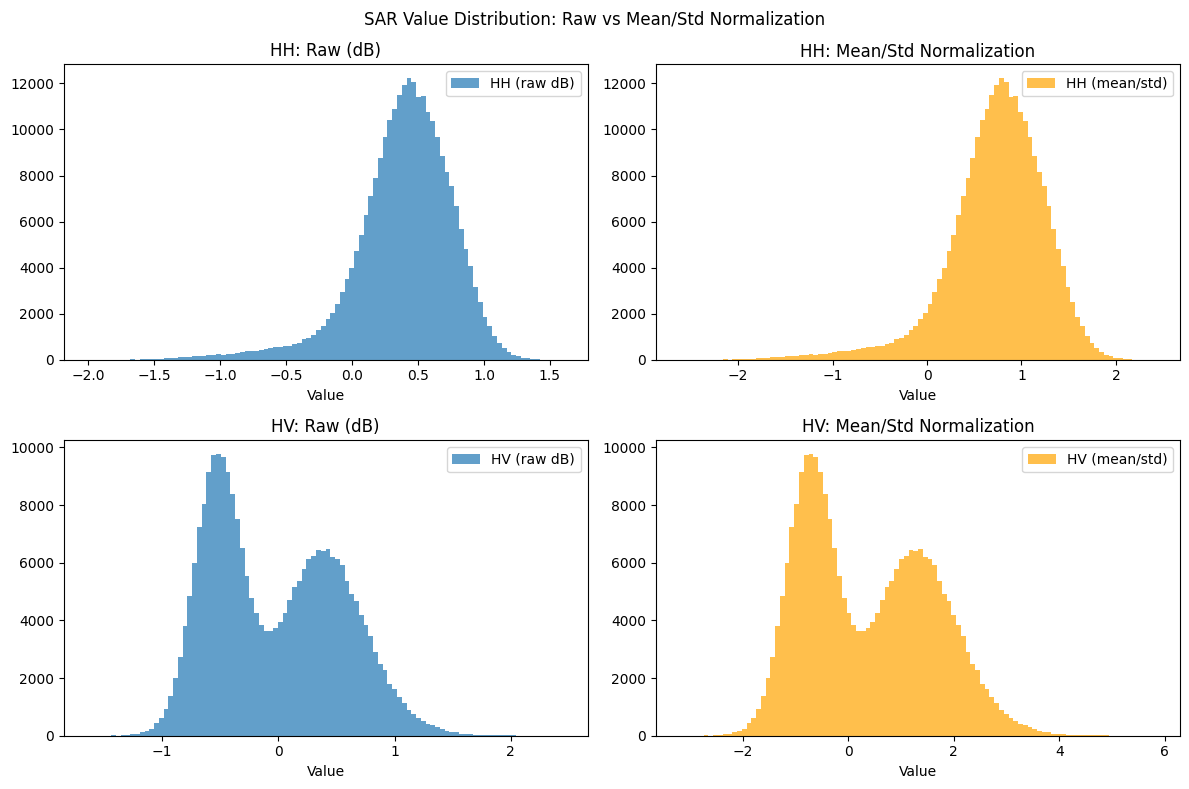

Key insight: mean/std normalization centers and scales values without altering dB semantics.


In [36]:
# Histogram comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# HH histograms
axes[0, 0].hist(image_raw[0].flatten(), bins=100, alpha=0.7, label='HH (raw dB)')
axes[0, 0].set_title('HH: Raw (dB)')
axes[0, 0].set_xlabel('Value')
axes[0, 0].legend()

axes[0, 1].hist(image_norm[0].flatten(), bins=100, alpha=0.7, color='orange', label='HH (mean/std)')
axes[0, 1].set_title('HH: Mean/Std Normalization')
axes[0, 1].set_xlabel('Value')
axes[0, 1].legend()

# HV histograms
axes[1, 0].hist(image_raw[1].flatten(), bins=100, alpha=0.7, label='HV (raw dB)')
axes[1, 0].set_title('HV: Raw (dB)')
axes[1, 0].set_xlabel('Value')
axes[1, 0].legend()

axes[1, 1].hist(image_norm[1].flatten(), bins=100, alpha=0.7, color='orange', label='HV (mean/std)')
axes[1, 1].set_title('HV: Mean/Std Normalization')
axes[1, 1].set_xlabel('Value')
axes[1, 1].legend()

fig.suptitle('SAR Value Distribution: Raw vs Mean/Std Normalization', fontsize=12)
plt.tight_layout()
plt.show()

print('Key insight: mean/std normalization centers and scales values without altering dB semantics.')


## 2. Downsampling (512 -> 128)

At 80m SAR resolution, a 512x512 crop covers ~40km x 40km. A typical CNN receptive field might only see a small fraction of this. By downsampling to 128x128:
- The same physical area is covered
- But the CNN can "see" the entire ice floe structure
- Prediction is upsampled back to 512x512 for final output

In [37]:
def load_full_scene(scene_name, split='train'):
    """Load full scene from memmap (raw, un-normalized)."""
    scene_dir = memmap_dir / split
    image_path = scene_dir / f'{scene_name}_image.npy'
    label_path = scene_dir / f'{scene_name}_label.npy'
    image_mmap = np.load(image_path, mmap_mode='r')
    label_mmap = np.load(label_path, mmap_mode='r')
    image = image_mmap.astype(np.float32)
    label = label_mmap.copy()
    return image, label


def downsample_full_scene(image, label, target_size):
    """Downsample full-scene image/label to target size."""
    image_t = torch.from_numpy(image).unsqueeze(0)  # [1, C, H, W]
    label_t = torch.from_numpy(label).unsqueeze(0).unsqueeze(0).float()  # [1, 1, H, W]

    image_down = F.interpolate(
        image_t, size=(target_size, target_size),
        mode='bilinear', align_corners=False
    ).squeeze(0).numpy()

    label_down = F.interpolate(
        label_t, size=(target_size, target_size),
        mode='nearest'
    ).squeeze(0).squeeze(0).numpy().astype(np.uint8)

    return image_down, label_down


In [38]:
# Load full scene and downsample to global context
full_image_raw, full_label = load_full_scene(scene_name)
full_image_std = apply_standard_normalization(full_image_raw)

# Downsample full scene to the same input size as training
global_image_std, global_label = downsample_full_scene(
    full_image_std, full_label, GLOBAL_TARGET_SIZE
)

scene_h, scene_w = full_label.shape
scene_km_h = scene_h * BASE_RES_M / 1000
scene_km_w = scene_w * BASE_RES_M / 1000

# Effective resolution after downsampling full scene
global_m_per_px_h = scene_h * BASE_RES_M / GLOBAL_TARGET_SIZE
global_m_per_px_w = scene_w * BASE_RES_M / GLOBAL_TARGET_SIZE

print(f'Full scene shape: {full_image_raw.shape} -> label {full_label.shape}')
print(f'Full scene coverage: ~{scene_km_h:.1f} km x {scene_km_w:.1f} km')
print(f'Global target size: {GLOBAL_TARGET_SIZE}x{GLOBAL_TARGET_SIZE}')
print(f'Approx resolution after downsample: {global_m_per_px_h:.0f}m x {global_m_per_px_w:.0f}m per pixel')


Full scene shape: (3, 4995, 5208) -> label (4995, 5208)
Full scene coverage: ~399.6 km x 416.6 km
Global target size: 512x512
Approx resolution after downsample: 780m x 814m per pixel


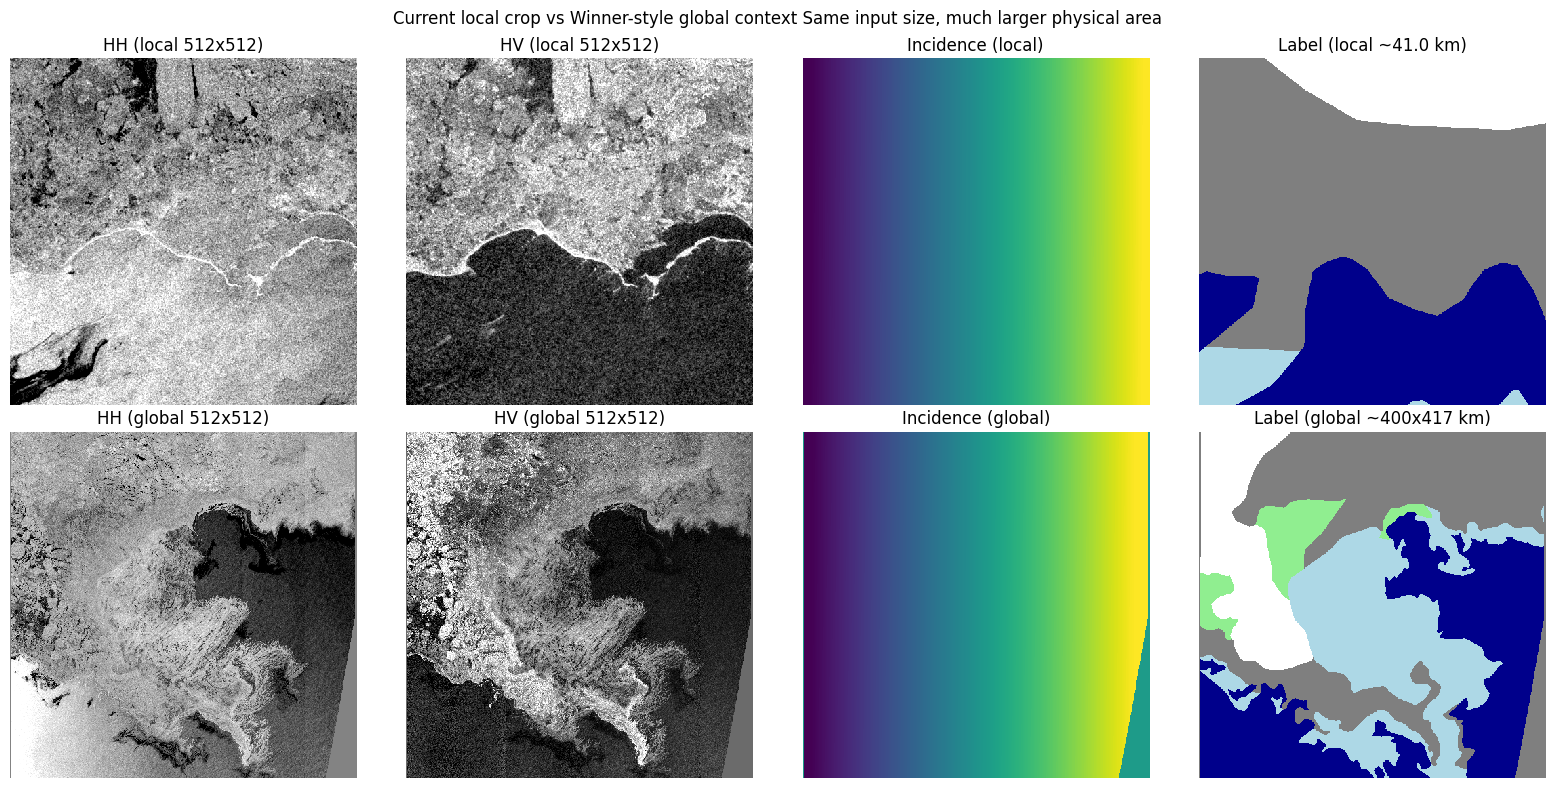

In [39]:
# Visualize local crop vs global-context downsample
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Local crop (current implementation)
for i, (ax, title) in enumerate(zip(axes[0, :3], [
    f'HH (local {crop_size}x{crop_size})',
    f'HV (local {crop_size}x{crop_size})',
    'Incidence (local)'
])):
    vmin, vmax = np.percentile(image_std[i], [2, 98])
    ax.imshow(image_std[i], cmap='gray' if i < 2 else 'viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')

axes[0, 3].imshow(colorize_label(label), interpolation='nearest')
axes[0, 3].set_title(f'Label (local ~{crop_size * BASE_RES_M / 1000:.1f} km)')
axes[0, 3].axis('off')

# Row 2: Full-scene downsample (winner-style global context)
for i, (ax, title) in enumerate(zip(axes[1, :3], [
    f'HH (global {GLOBAL_TARGET_SIZE}x{GLOBAL_TARGET_SIZE})',
    f'HV (global {GLOBAL_TARGET_SIZE}x{GLOBAL_TARGET_SIZE})',
    'Incidence (global)'
])):
    vmin, vmax = np.percentile(global_image_std[i], [2, 98])
    ax.imshow(global_image_std[i], cmap='gray' if i < 2 else 'viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')

axes[1, 3].imshow(colorize_label(global_label), interpolation='nearest')
axes[1, 3].set_title(f'Label (global ~{scene_km_h:.0f}x{scene_km_w:.0f} km)')
axes[1, 3].axis('off')

fig.suptitle('Current local crop vs Winner-style global context Same input size, much larger physical area', fontsize=12)
plt.tight_layout()
plt.show()


In [40]:
# Demonstrate receptive field coverage
print('Receptive Field Analysis:')
print('=' * 50)
print(f'Local crop: {crop_size} px @ {BASE_RES_M}m -> ~{crop_size * BASE_RES_M / 1000:.1f} km')
print(f'Full scene: {scene_h}x{scene_w} px -> ~{scene_km_h:.1f} km x {scene_km_w:.1f} km')
print(f'Global target: {GLOBAL_TARGET_SIZE} px -> ~{global_m_per_px_h:.0f}m x {global_m_per_px_w:.0f}m per pixel')
print()
print('Key insight: global downsample keeps the same input size but expands physical coverage.')


Receptive Field Analysis:
Local crop: 512 px @ 80m -> ~41.0 km
Full scene: 4995x5208 px -> ~399.6 km x 416.6 km
Global target: 512 px -> ~780m x 814m per pixel

Key insight: global downsample keeps the same input size but expands physical coverage.


## 3. Month Encoding

Sea ice behaves differently by season:
- Winter: More new ice formation, different backscatter
- Summer: Melting, wet surfaces, different texture

Adding month as a 4th channel helps the model learn seasonal patterns.

In [41]:
def extract_month(scene_name):
    """Extract month from scene name (YYYYMMDD format)."""
    try:
        month = int(scene_name[4:6])
        return month
    except (ValueError, IndexError):
        return 6  # Default to June


def add_month_channel(image, scene_name):
    """Add month as 4th channel, normalized to [0, 1]."""
    month = extract_month(scene_name)
    month_value = (month - 1) / 11.0  # Normalize to [0, 1]
    
    month_channel = np.full(
        (1, image.shape[1], image.shape[2]),
        month_value, dtype=np.float32
    )
    
    return np.concatenate([image, month_channel], axis=0)

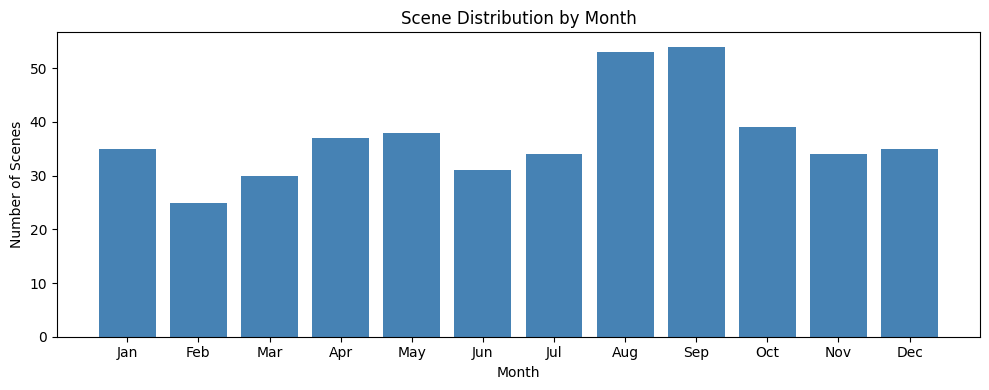

Month distribution:
  Jan: 35 scenes
  Feb: 25 scenes
  Mar: 30 scenes
  Apr: 37 scenes
  May: 38 scenes
  Jun: 31 scenes
  Jul: 34 scenes
  Aug: 53 scenes
  Sep: 54 scenes
  Oct: 39 scenes
  Nov: 34 scenes
  Dec: 35 scenes


In [42]:
# Analyze month distribution in dataset
month_counts = {}
for name in scene_names:
    month = extract_month(name)
    month_counts[month] = month_counts.get(month, 0) + 1

months = sorted(month_counts.keys())
counts = [month_counts[m] for m in months]

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 4))
plt.bar([month_names[m-1] for m in months], counts, color='steelblue')
plt.xlabel('Month')
plt.ylabel('Number of Scenes')
plt.title('Scene Distribution by Month')
plt.tight_layout()
plt.show()

print('Month distribution:')
for m in months:
    print(f'  {month_names[m-1]}: {month_counts[m]} scenes')

In [43]:
# Show month channel for current patch
month = extract_month(scene_name)
image_with_month = add_month_channel(image_norm, scene_name)

print(f'Scene: {scene_name}')
print(f'Extracted month: {month} ({month_names[month-1]})')
print(f'Month channel value: {(month - 1) / 11.0:.3f}')
print(f'Image shape with month: {image_with_month.shape}')


Scene: 20191016T155300_cis_prep
Extracted month: 10 (Oct)
Month channel value: 0.818
Image shape with month: (4, 512, 512)


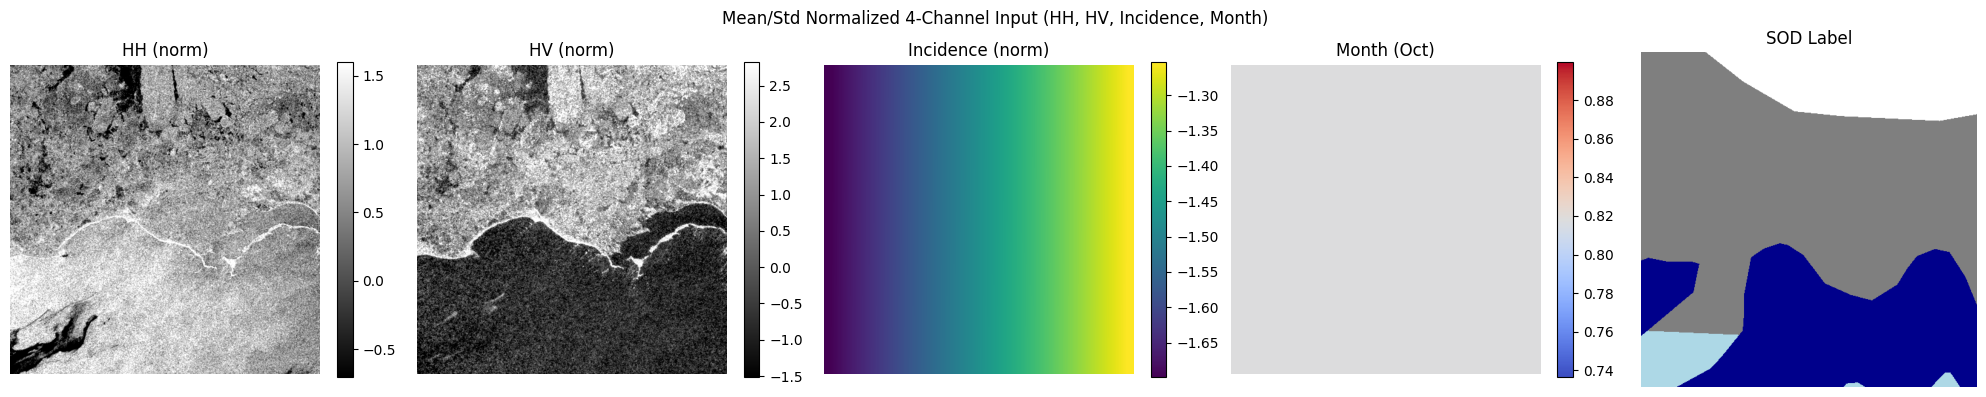

In [44]:
# Visualize all 4 channels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

channel_names = ['HH (norm)', 'HV (norm)', 'Incidence (norm)', f'Month ({month_names[month-1]})', 'SOD Label']

for i in range(4):
    vmin, vmax = np.percentile(image_with_month[i], [2, 98])
    cmap = 'gray' if i < 2 else ('viridis' if i == 2 else 'coolwarm')
    im = axes[i].imshow(image_with_month[i], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[i].set_title(channel_names[i])
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046)

axes[4].imshow(colorize_label(label))
axes[4].set_title(channel_names[4])
axes[4].axis('off')

fig.suptitle('Mean/Std Normalized 4-Channel Input (HH, HV, Incidence, Month)', fontsize=12)
plt.tight_layout()
plt.show()


## 4. Full Pipeline Comparison

Compare the complete transformation pipeline:
1. Raw SAR (already dB) -> Mean/Std normalization -> Add month -> Downsample


In [45]:
def apply_full_pipeline(image_raw, label, scene_name, downsample_size=GLOBAL_TARGET_SIZE):
    """Apply winner-style pipeline (mean/std + month + downsample)."""
    # 1. Mean/std normalization
    image_norm = apply_standard_normalization(image_raw)

    # 2. Add month channel
    image_month = add_month_channel(image_norm, scene_name)

    # 3. Downsample to target size
    image_down, label_down = downsample_full_scene(image_month, label, downsample_size)

    return image_down, label_down


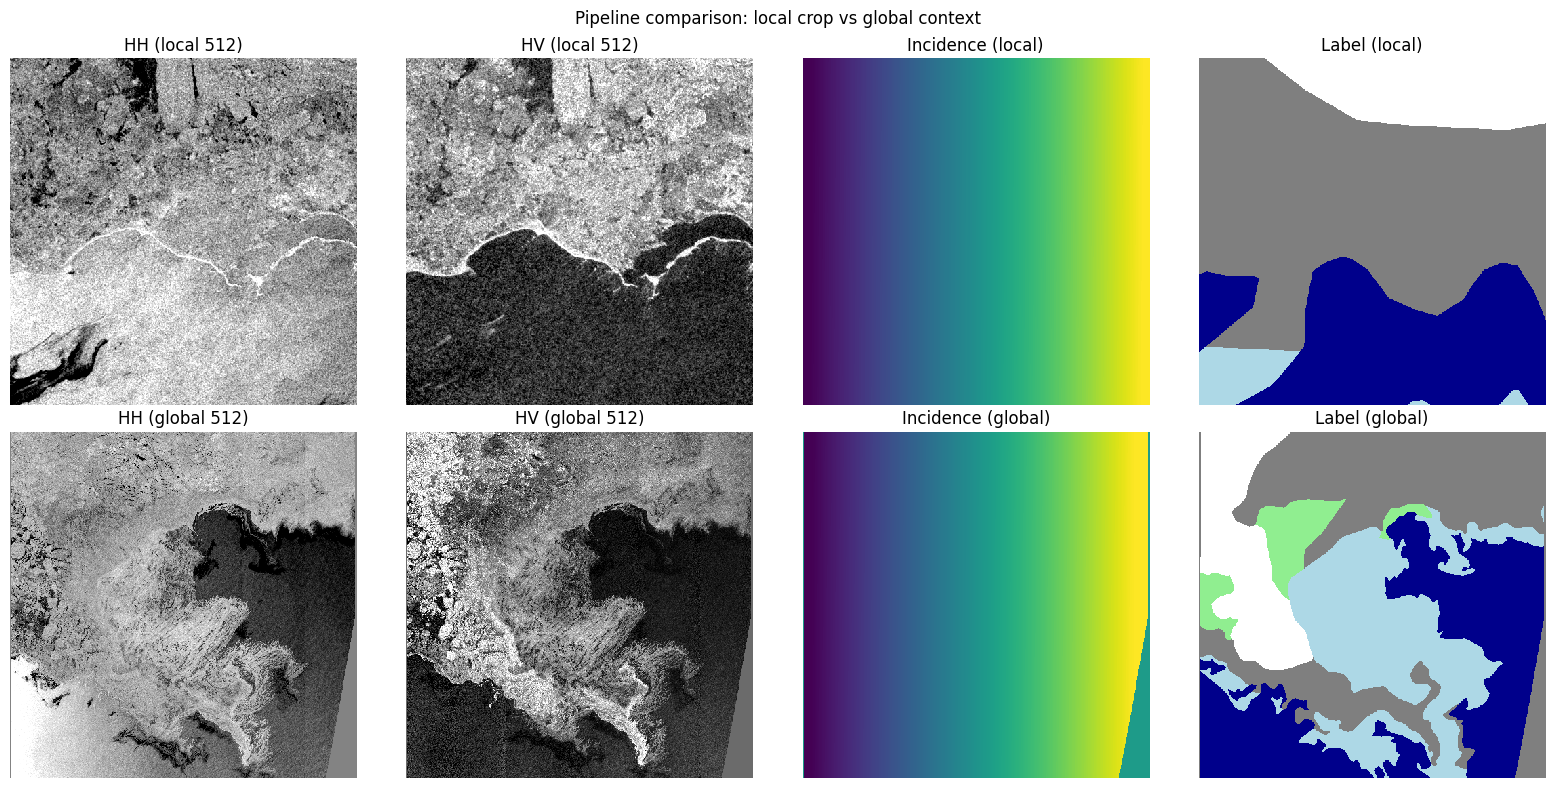

In [46]:
# Compare local patch vs full-scene global context (pipeline)
image_raw, label, scene_name, (r, c) = load_raw_patch(patch_idx)
full_image_raw, full_label = load_full_scene(scene_name)

local_final, local_label = apply_full_pipeline(image_raw, label, scene_name, downsample_size=crop_size)
global_final, global_label = apply_full_pipeline(full_image_raw, full_label, scene_name, downsample_size=GLOBAL_TARGET_SIZE)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Local patch (pipeline)
for i, (ax, title) in enumerate(zip(axes[0, :3], [
    f'HH (local {crop_size})',
    f'HV (local {crop_size})',
    'Incidence (local)'
])):
    vmin, vmax = np.percentile(local_final[i], [2, 98])
    ax.imshow(local_final[i], cmap='gray' if i < 2 else 'viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')

axes[0, 3].imshow(colorize_label(local_label), interpolation='nearest')
axes[0, 3].set_title('Label (local)')
axes[0, 3].axis('off')

# Row 2: Global context (pipeline)
for i, (ax, title) in enumerate(zip(axes[1, :3], [
    f'HH (global {GLOBAL_TARGET_SIZE})',
    f'HV (global {GLOBAL_TARGET_SIZE})',
    'Incidence (global)'
])):
    vmin, vmax = np.percentile(global_final[i], [2, 98])
    ax.imshow(global_final[i], cmap='gray' if i < 2 else 'viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')

axes[1, 3].imshow(colorize_label(global_label), interpolation='nearest')
axes[1, 3].set_title('Label (global)')
axes[1, 3].axis('off')

fig.suptitle('Pipeline comparison: local crop vs global context', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Multi-scene comparison: local vs global context

def select_patch_indices(num_scenes=4, seed=123):
    rng = random.Random(seed)
    if classes_per_crop is None:
        return rng.sample(range(len(coords)), k=min(num_scenes, len(coords)))

    rare_classes = {1, 2, 3}
    candidates = [
        i for i, classes in enumerate(classes_per_crop)
        if len(classes) >= 2 and any(c in rare_classes for c in classes)
    ]

    if len(candidates) < num_scenes:
        candidates = [i for i, classes in enumerate(classes_per_crop) if len(classes) >= 2]

    if len(candidates) < num_scenes:
        candidates = list(range(len(coords)))

    return rng.sample(candidates, k=min(num_scenes, len(candidates)))


NUM_SCENES = 4
patch_indices = select_patch_indices(NUM_SCENES, seed=42)
print('Selected patch indices:', patch_indices)

fig, axes = plt.subplots(NUM_SCENES, 4, figsize=(16, 4 * NUM_SCENES))
if NUM_SCENES == 1:
    axes = np.expand_dims(axes, 0)

for row, idx in enumerate(patch_indices):
    image_raw, label, scene_name, (r, c) = load_raw_patch(idx)
    full_image_raw, full_label = load_full_scene(scene_name)

    local_final, local_label = apply_full_pipeline(image_raw, label, scene_name, downsample_size=crop_size)
    global_final, global_label = apply_full_pipeline(full_image_raw, full_label, scene_name, downsample_size=GLOBAL_TARGET_SIZE)

    # Local HH
    vmin, vmax = np.percentile(local_final[0], [2, 98])
    axes[row, 0].imshow(local_final[0], cmap='gray', vmin=vmin, vmax=vmax, interpolation='nearest')
    axes[row, 0].set_title(f'Local HH ({scene_name})')
    axes[row, 0].axis('off')

    # Local label
    axes[row, 1].imshow(colorize_label(local_label), interpolation='nearest')
    axes[row, 1].set_title('Local label')
    axes[row, 1].axis('off')

    # Global HH
    vmin, vmax = np.percentile(global_final[0], [2, 98])
    axes[row, 2].imshow(global_final[0], cmap='gray', vmin=vmin, vmax=vmax, interpolation='nearest')
    axes[row, 2].set_title('Global HH')
    axes[row, 2].axis('off')

    # Global label
    axes[row, 3].imshow(colorize_label(global_label), interpolation='nearest')
    axes[row, 3].set_title('Global label')
    axes[row, 3].axis('off')

fig.suptitle('Multi-scene comparison: local crop vs global context (HH + labels)', fontsize=12)
plt.tight_layout()
plt.show()


## 5. Class Legend

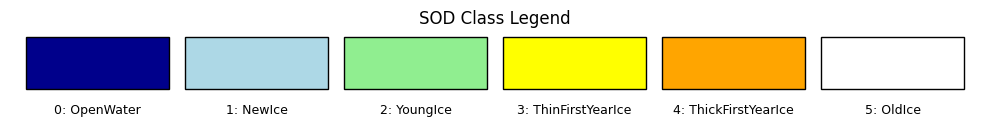

In [47]:
# Create legend showing class colors
fig, ax = plt.subplots(figsize=(10, 1.5))

for i, (name, color) in enumerate(zip(CLASS_NAMES, PALETTE)):
    ax.add_patch(plt.Rectangle((i, 0), 0.9, 1, facecolor=color, edgecolor='black'))
    ax.text(i + 0.45, -0.3, f'{i}: {name}', ha='center', va='top', fontsize=9)

ax.set_xlim(-0.1, len(CLASS_NAMES))
ax.set_ylim(-0.8, 1.1)
ax.axis('off')
ax.set_title('SOD Class Legend', fontsize=12)
plt.tight_layout()
plt.show()

## Summary

The Winner's Recipe from MMSeaIce addresses key challenges in SAR sea ice classification:

| Technique | Problem Solved | Implementation |
|-----------|---------------|----------------|
| **Mean/Std Normalization** | SAR already in dB; standardize channels | `(x - mean) / std` |
| **Downsampling** | CNN can't see full ice floe structure | 512x512 -> 128x128 (bilinear) |
| **Month Encoding** | Ice behavior varies by season | Add month as 4th channel [0,1] |

To enable these in training (crop mode):
```bash
python src/train.py --downsample 128 --use_month
```

For full-scene global context:
```bash
python src/train.py --full_scene --use_month
```


In [48]:
print("Winner's Recipe Note:")
print('=' * 60)
print('The winning approach downsampled the FULL scene to ~500x500 (800m/px),')
print('so the model sees ~400x400 km of context in a single input.')
print()
print('This is different from just downsampling a 512x512 crop.')
print('To match the winner, you need full-scene downsampled inputs (global context).')


Winner's Recipe Note:
The winning approach downsampled the FULL scene to ~500x500 (800m/px),
so the model sees ~400x400 km of context in a single input.

This is different from just downsampling a 512x512 crop.
To match the winner, you need full-scene downsampled inputs (global context).
